In [144]:
import jax.numpy as np
from scipy.special import j1, jvp, jv

# Define the x grid
x_min = 1e-6
x_max = 300
n_points = 200000
x = np.linspace(x_min, x_max, n_points)

# Compute S(x) = J1(x)^2 / x^2
S = (j1(x)**2) / x**2

# Compute S'(x) analytically
# chatpgt did it wrong. put the index in the wrong spot. it still diverges. FML.
J1p = jvp(1, x)
S_prime = (2 * j1(x) * J1p) / x**2 - 2 * (j1(x)**2) / x**3

#S_prime = - 2 * jv(x, 2) * j1(x) / x**2
# Integrand: (2*S + x*S')^2 / S * x
integrand = ((2 * S + x * S_prime)**2 / S) * x

# Perform trapezoidal integration to get the dimensionless constant C2
C2 = np.trapezoid(integrand, x)

# Display the result
print(f"Dimensionless constant C2 ≈ {C2:.5f}")


Dimensionless constant C2 ≈ 380.60855


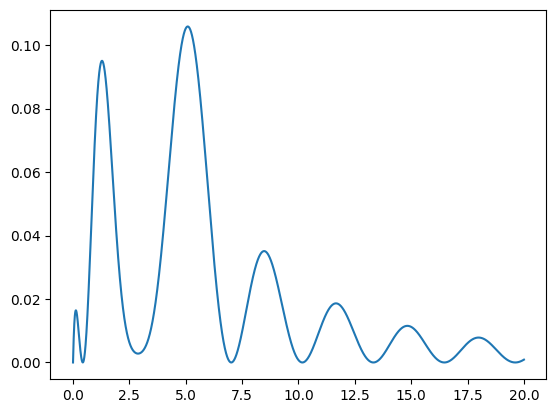

In [23]:
import matplotlib.pyplot as plt
plt.plot(x,integrand)
plt.show()

In [24]:
integrand_2 = (4 * j1(x)**2/x**2 + 4 * jv(x,2)**2 - 8* j1(x) * jv(x,2)/x)*x 

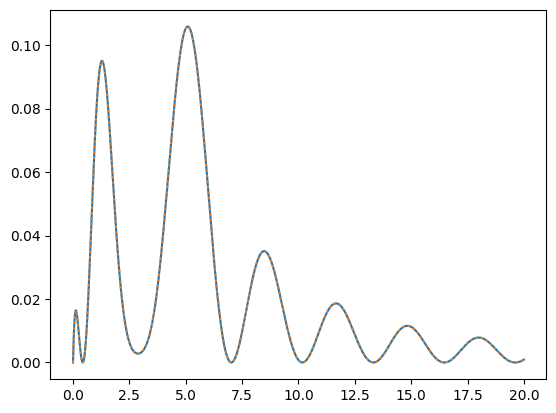

In [25]:
plt.plot(x,integrand_2)
plt.plot(x, integrand, linestyle=':')
plt.show()

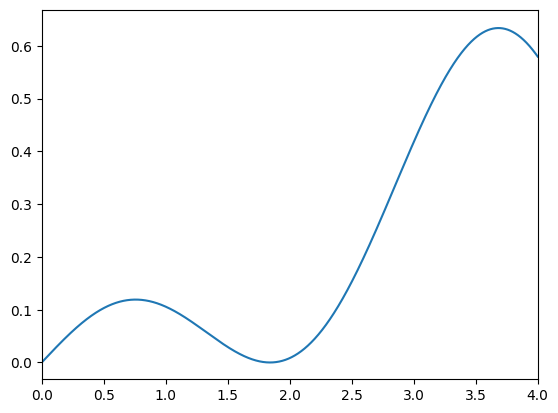

In [43]:
integrand_3 = (jv(2,x)**2 + j1(x)**2/x**2 - 2 * j1(x) * jv(2,x)/x )*x
plt.plot(x,integrand_3)
plt.xlim(0,4)
plt.show()

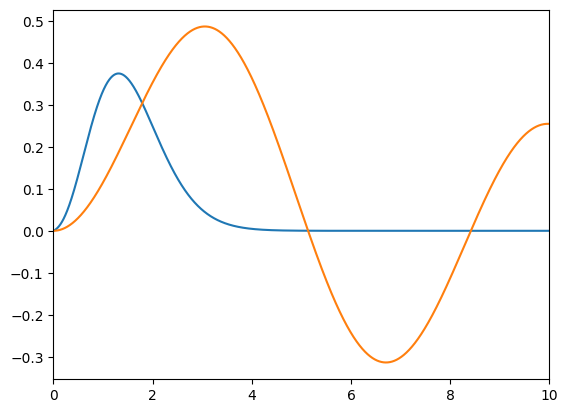

In [ ]:
plt.plot(x, (jv(x,2)**2) * x)
plt.plot(x, jv(2,x))
plt.xlim(0,10)
plt.show()

In [34]:
# it looks like I was simply trolled by desmos? my stuff converges just fine.
np.trapezoid(jv(x,2)**2 * x, x)

np.float64(0.6372811137245334)

In [36]:
np.trapezoid(integrand_3, x)

np.float64(0.12173722358766906)

In [147]:
print(np.trapezoid(jv(2,x)*jv(1,x)/x,x))
from scipy.special import gamma
print(1/(2*gamma(5/2)*gamma(1/2)))

0.21220405
0.2122065907891938


In [46]:
np.trapezoid(x*jv(2,x)**2,x)

np.float64(6366.146382400342)

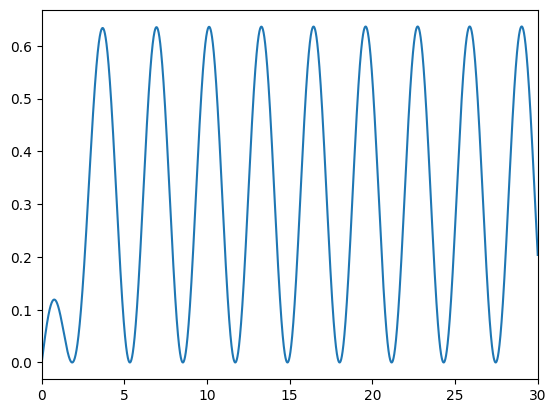

np.float64(9.199238362470659)

In [62]:
plt.plot(x, j1(x)**2/x - 2*j1(x)*jv(2,x)+jv(2,x)**2 * x)
plt.xlim(0,30)
plt.show()
np.trapezoid(j1(x)**2/x - 2*j1(x)*jv(2,x) + jv(2,x)**2 * x,x)

In [63]:
# Define the x grid
x_min = 1e-6
dx= 0.01

x_maximum = 100
dxmax = 1

x_maxes = np.linspace(x_min, x_maximum, int(x_maximum/dxmax))
integrals = []

for x_max in x_maxes:
    x = np.linspace(x_min, x_max, int(x_max/dx))
    integral = np.trapezoid(j1(x)**2/x - 2*j1(x)*jv(2,x) + jv(2,x)**2 * x,x)
    integrals.append(integral)


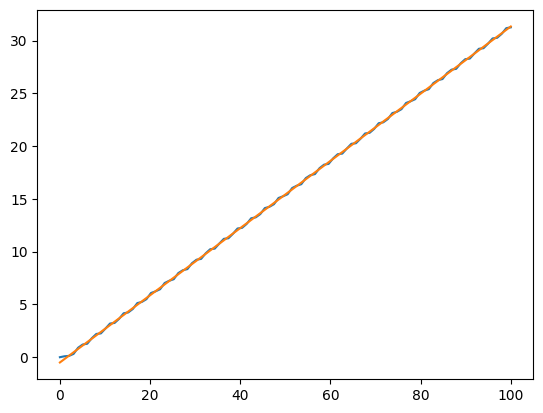

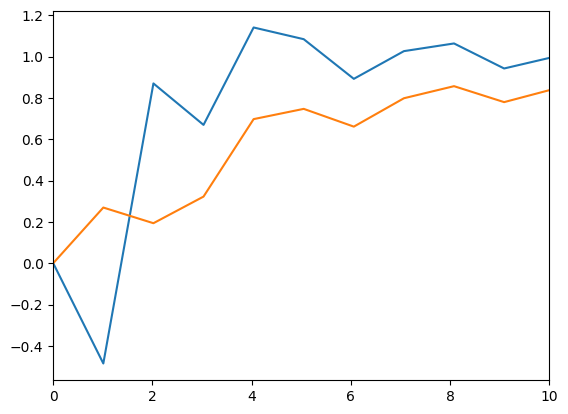

In [71]:
plt.plot(x_maxes,integrals)
plt.plot(x_maxes, x_maxes/np.pi - 0.5)
plt.show()

plt.plot(x_maxes, integrals/(x_maxes/np.pi - 0.5))
plt.plot(x_maxes, integrals/(x_maxes/np.pi))
plt.xlim(0,10)
plt.show()

In [83]:
# clearly, the -0.5 is important enough.
import dLux as dl
import dLux.utils as dlu
import jax.random as jr

In [111]:

wf_npix = 512
diameter = 0.125
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5*diameter)

psf_npix = 64
psf_pixel_scale = 0.375 #arcsec
oversample = 16

layers = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    )
]

optics = dl.AngularOpticalSystem(
    wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample
)

flux = 100
wavelength = 585e-9
source = dl.PointSource(np.array([wavelength]),flux = flux)

telescope = dl.Telescope(optics, ('source', source))

In [100]:
psf = telescope.model()
data = jr.poisson(jr.PRNGKey(0), psf)

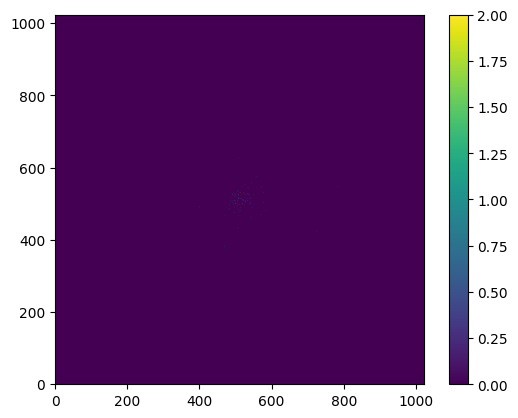

In [101]:
plt.imshow(data, origin='lower')
# plt.xlim(500,550)
# plt.ylim(500,550)
plt.colorbar()
plt.show()

In [113]:
# ok, now lets do some proper parameter inference ey!
import numpyro as npy
import numpyro.distributions as dist

parameters = ['wavelengths']

def psf_model(data, model):
    
    values = [
        npy.sample("wavelength",    dist.Uniform(wavelength*0.9, wavelength*1.1))
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten()
        )
        return npy.sample("psf", poisson_model, obs=data.flatten())
    

In [115]:
from jax import device_count
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data, telescope)

sample: 100%|██████████| 4000/4000 [22:02<00:00,  3.03it/s, 3 steps of size 8.84e-01. acc. prob=0.93]   

CPU times: user 2h 19min 33s, sys: 1min 34s, total: 2h 21min 7s
Wall time: 22min 6s


In [119]:
sampler.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
  wavelength      0.00      0.00      0.00      0.00      0.00    792.74      1.00

Number of divergences: 5


In [120]:
samples = sampler.get_samples()

In [128]:
print(samples.items())

dict_items([('wavelength', Array([5.8381573e-07, 5.8554787e-07, 5.8412570e-07, ..., 5.7998301e-07,
       5.7904629e-07, 5.8904180e-07], dtype=float32))])


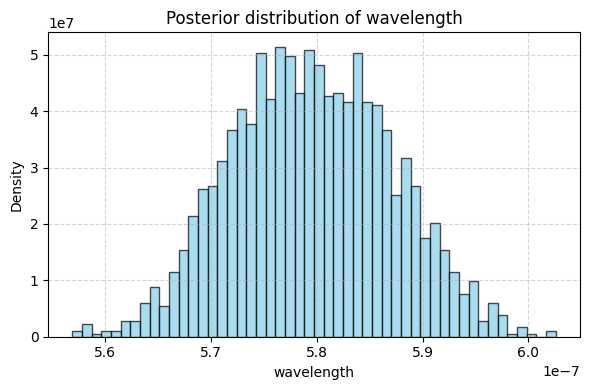

In [125]:
for param, values in samples.items():
    plt.figure(figsize=(6, 4))
    plt.hist(values.flatten(), bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f"Posterior distribution of {param}")
    plt.xlabel(param)
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [135]:
for param, values in samples.items():
    print(np.median(values.flatten()))
    print(np.std(values.flatten()))
    print(np.abs(np.median(values.flatten())-wavelength))

5.7944953e-07
7.527995e-09
5.5504756e-09


In [ ]:
rmax = np.sqrt(2)*dlu.arcsec2rad(psf_npix * psf_pixel_scale/2) # divide by 2 for radius, sqrt2 because more pixels along the diagonal.
crb = wavelength**(3/2)/(2*(flux*(2*diameter*rmax - wavelength))**0.5)
betamax = rmax*np.pi*diameter/wavelength
print(betamax) # hopefully > 10, yes!

55.230007


In [141]:
print(crb)
# nice, of a reasonable order!

5.0045346e-09
